# Image Coloring with Convolutional Autoencoders

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split, DataLoader
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import math
from PIL import Image
from PIL import Image
from IPython.display import display
import glob

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
transformObj = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

In [4]:
transformObjOri = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.ToTensor(),
])

In [5]:
X_train = torch.FloatTensor(1000, 3, 256, 256)
y_train = torch.FloatTensor(1000, 3, 256, 256)
y_train_display = []
counter = 0
for filename in glob.glob('Cars/*.jpg'):
    im = Image.open(filename)
    #display(transforms.ToPILImage(mode='RGB')(transformObj(im).repeat(3, 1, 1)))
    X_train[counter] = (transformObj(im).repeat(3, 1, 1))
    y_train[counter] = (transformObjOri(im))[:3,:,:]
    y_train_display.append(im)
    if counter%500==0:
        print(counter)
    counter += 1
    if counter >= 1000:
        break

0
500


In [6]:
len(X_train)

1000

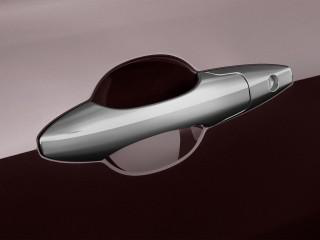

In [7]:
y_train_display[257]

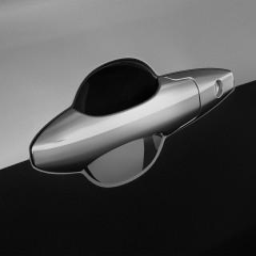

In [8]:
displayingPIL = transforms.ToPILImage(mode='RGB')
displayingPIL(X_train[257])

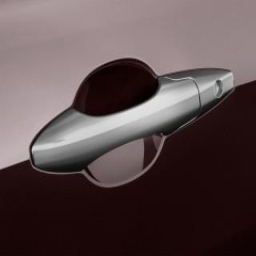

In [9]:
displayingPIL(y_train[257])

In [10]:
X_train.shape

torch.Size([1000, 3, 256, 256])

In [11]:
y_train.shape

torch.Size([1000, 3, 256, 256])

In [12]:
#X_train = X_train.cuda()
#X_train.is_cuda

In [13]:
#y_train = y_train.cuda()
#y_train.is_cuda

In [14]:
class Pokemon(Dataset):
    def __init__(self, x1, y1):
        self.x1 = x1
        self.y1 = y1

    def __len__(self):
        return len(self.x1)

    def __getitem__(self, index):
        return self.x1[index], self.y1[index]

In [15]:
data = Pokemon(X_train, y_train)

In [16]:
dataITER = DataLoader(data, batch_size=2)

In [17]:
counter = 0
len(data)

1000

In [18]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=4, padding=2),
            nn.ReLU(True),
            #nn.MaxPool2d(3),
            
            nn.Conv2d(in_channels=6, out_channels=10, kernel_size=4, padding=2),
            nn.ReLU(True),
            #nn.MaxPool2d(3),
            
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=4, padding=2),
            nn.ReLU(True),
            #nn.MaxPool2d(3),
            
            nn.Conv2d(in_channels=20, out_channels=40, kernel_size=4, padding=2),
            nn.ReLU(True),
            #nn.MaxPool2d(3)
            
            nn.Conv2d(in_channels=40, out_channels=50, kernel_size=4, padding=2),
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=50, out_channels=40, kernel_size=4, padding=2),
            nn.ReLU(True),
            
            #nn.UpsamplingNearest2d(19),
            nn.ConvTranspose2d(in_channels=40, out_channels=20, kernel_size=4, padding=2),
            nn.ReLU(True),
            
            #nn.UpsamplingNearest2d(56),
            nn.ConvTranspose2d(in_channels=20, out_channels=10, kernel_size=4, padding=2),
            nn.ReLU(True),
            
            #nn.UpsamplingNearest2d(168),
            nn.ConvTranspose2d(in_channels=10, out_channels=6, kernel_size=4, padding=2),
            nn.ReLU(True),
            
            #nn.UpsamplingNearest2d(254),
            nn.ConvTranspose2d(in_channels=6, out_channels=3, kernel_size=4, padding=2),
            nn.ReLU(True)
        )

    def forward(self, input):
        return self.decoder(self.encoder(input))

In [19]:
model = Autoencoder()
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 6, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(6, 10, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): Conv2d(20, 40, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (7): ReLU(inplace=True)
    (8): Conv2d(40, 50, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (9): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(50, 40, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(40, 20, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(20, 10, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(10, 6, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  

In [20]:
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 257, 257]             294
              ReLU-2          [-1, 6, 257, 257]               0
            Conv2d-3         [-1, 10, 258, 258]             970
              ReLU-4         [-1, 10, 258, 258]               0
            Conv2d-5         [-1, 20, 259, 259]           3,220
              ReLU-6         [-1, 20, 259, 259]               0
            Conv2d-7         [-1, 40, 260, 260]          12,840
              ReLU-8         [-1, 40, 260, 260]               0
            Conv2d-9         [-1, 50, 261, 261]          32,050
             ReLU-10         [-1, 50, 261, 261]               0
  ConvTranspose2d-11         [-1, 40, 260, 260]          32,040
             ReLU-12         [-1, 40, 260, 260]               0
  ConvTranspose2d-13         [-1, 20, 259, 259]          12,820
             ReLU-14         [-1, 20, 2

In [21]:
X_train = X_train.to(device)
X_train.is_cuda

True

In [22]:
criterion = nn.L1Loss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

Epoch:  1 | Loss:  0.21793091297149658


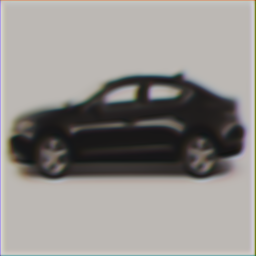

Epoch:  2 | Loss:  0.1821085810661316


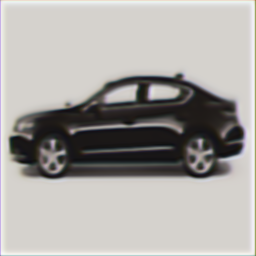

Epoch:  3 | Loss:  0.19074895977973938


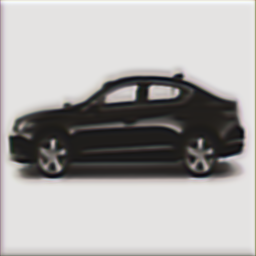

Epoch:  4 | Loss:  0.16007795929908752


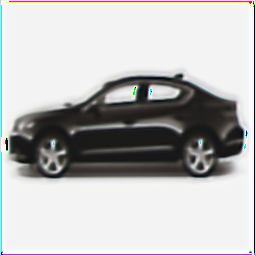

Epoch:  5 | Loss:  0.18471238017082214


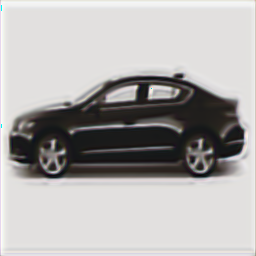

Epoch:  6 | Loss:  0.17755262553691864


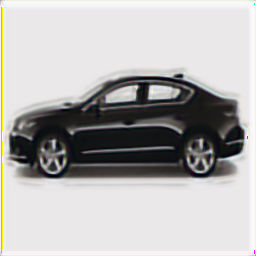

Epoch:  7 | Loss:  0.16733962297439575


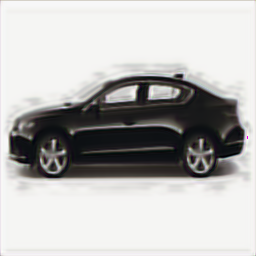

Epoch:  8 | Loss:  0.15540152788162231


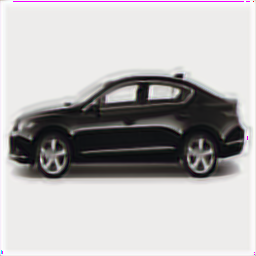

Epoch:  9 | Loss:  0.16377128660678864


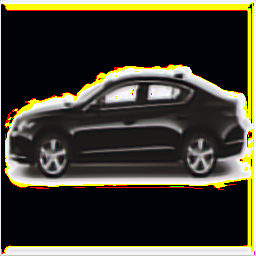

Epoch:  10 | Loss:  0.15800565481185913


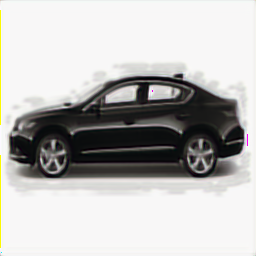

Epoch:  11 | Loss:  0.18678739666938782


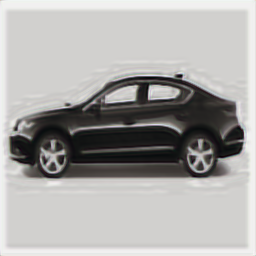

Epoch:  12 | Loss:  0.15858837962150574


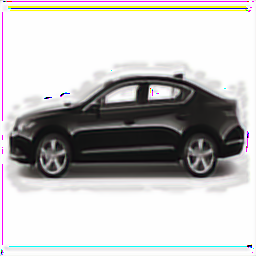

Epoch:  13 | Loss:  0.16319690644741058


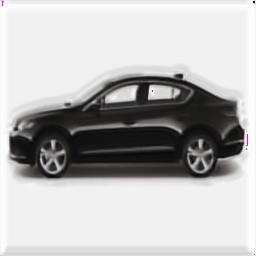

Epoch:  14 | Loss:  0.1578056365251541


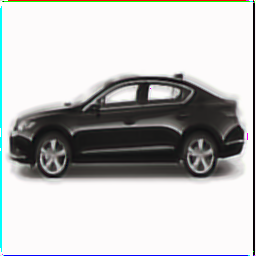

Epoch:  15 | Loss:  0.1806570291519165


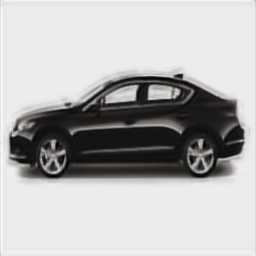

Epoch:  16 | Loss:  0.15920542180538177


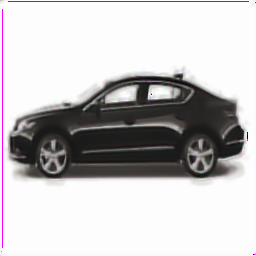

Epoch:  17 | Loss:  0.17606765031814575


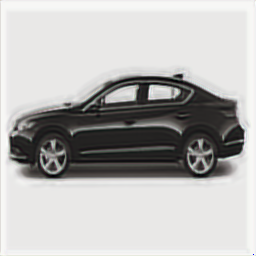

Epoch:  18 | Loss:  0.1533069908618927


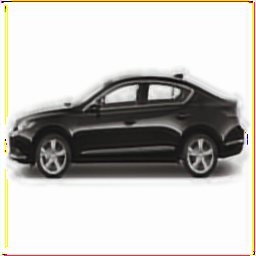

Epoch:  19 | Loss:  0.15641970932483673


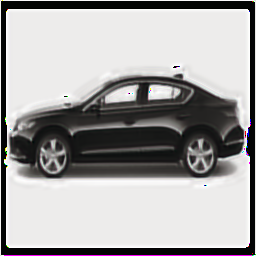

Epoch:  20 | Loss:  0.17024236917495728


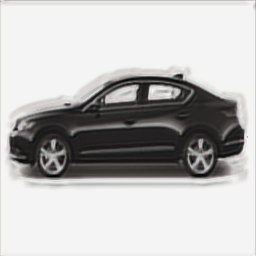

Epoch:  21 | Loss:  0.15595367550849915


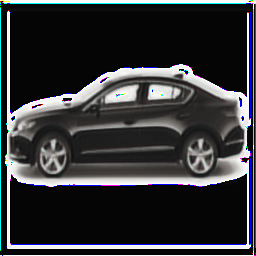

Epoch:  22 | Loss:  0.16065040230751038


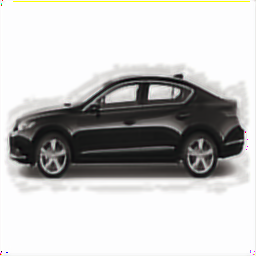

Epoch:  23 | Loss:  0.15680699050426483


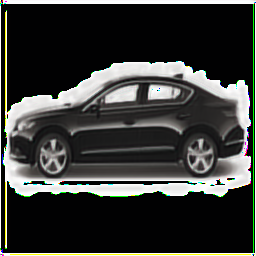

Epoch:  24 | Loss:  0.16558197140693665


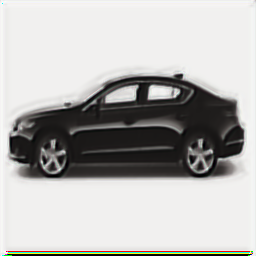

Epoch:  25 | Loss:  0.17666387557983398


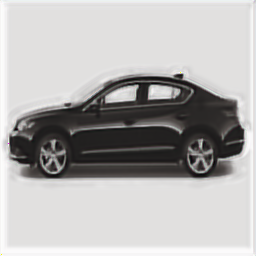

Epoch:  26 | Loss:  0.15424871444702148


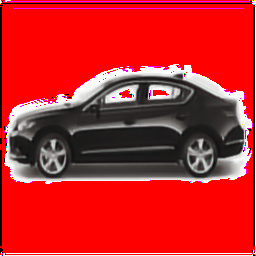

Epoch:  27 | Loss:  0.1580202877521515


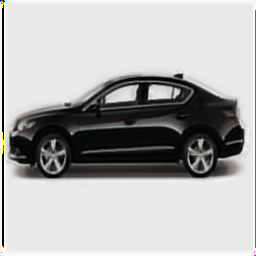

Epoch:  28 | Loss:  0.15407511591911316


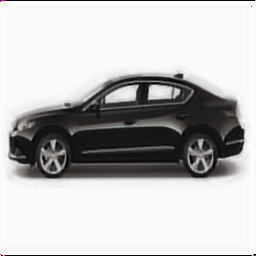

Epoch:  29 | Loss:  0.1555817723274231


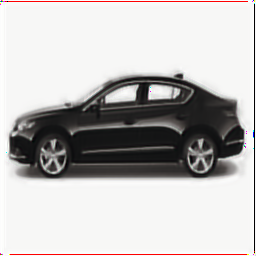

Epoch:  30 | Loss:  0.18940314650535583


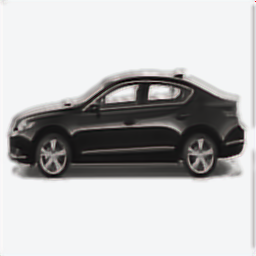

Epoch:  31 | Loss:  0.15306678414344788


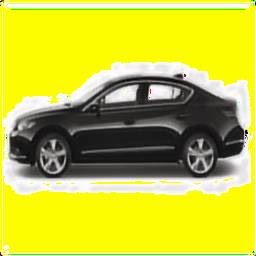

Epoch:  32 | Loss:  0.16929349303245544


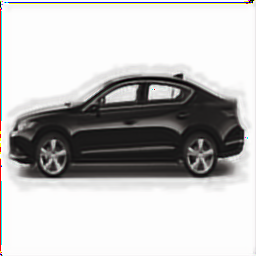

Epoch:  33 | Loss:  0.15273895859718323


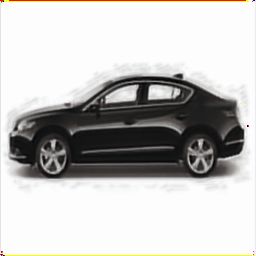

Epoch:  34 | Loss:  0.15427276492118835


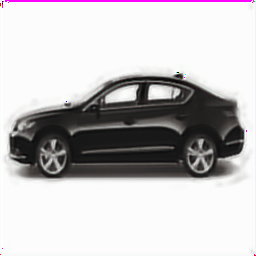

Epoch:  35 | Loss:  0.1733010709285736


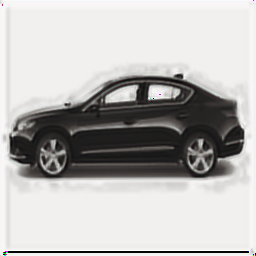

Epoch:  36 | Loss:  0.16141793131828308


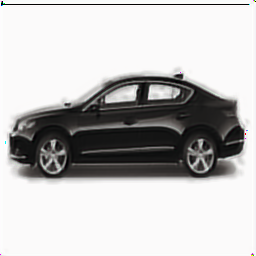

Epoch:  37 | Loss:  0.1763177365064621


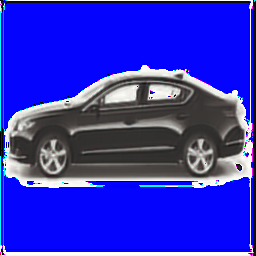

Epoch:  38 | Loss:  0.15968966484069824


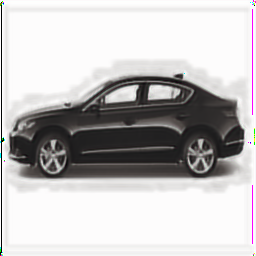

Epoch:  39 | Loss:  0.1612633615732193


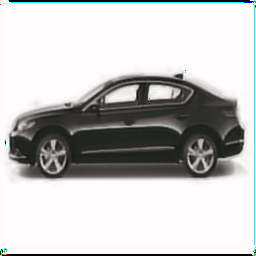

Epoch:  40 | Loss:  0.17399494349956512


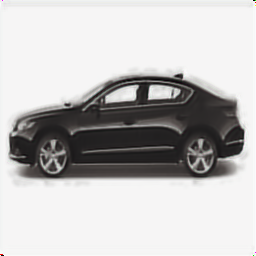

Epoch:  41 | Loss:  0.1705142855644226


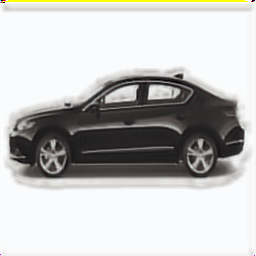

Epoch:  42 | Loss:  0.1572253704071045


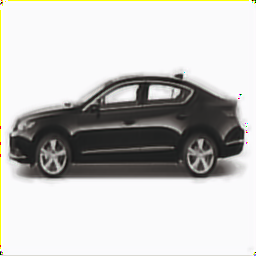

Epoch:  43 | Loss:  0.17391185462474823


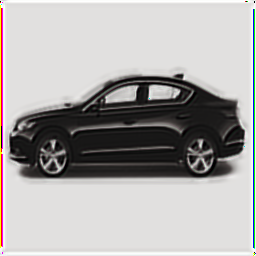

Epoch:  44 | Loss:  0.17109712958335876


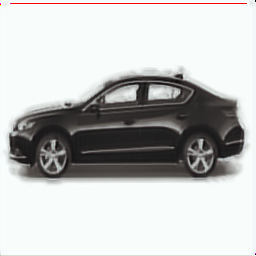

Epoch:  45 | Loss:  0.18457476794719696


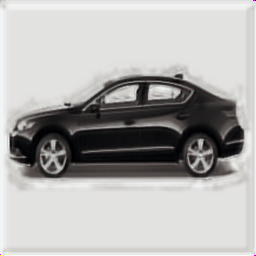

Epoch:  46 | Loss:  0.1918434351682663


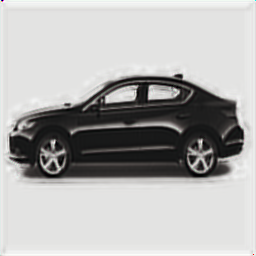

Epoch:  47 | Loss:  0.16010558605194092


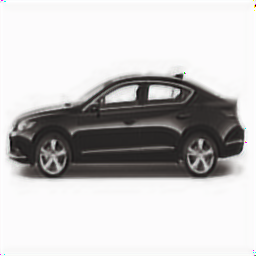

Epoch:  48 | Loss:  0.1630774438381195


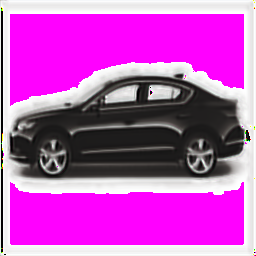

Epoch:  49 | Loss:  0.16591736674308777


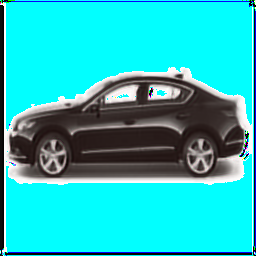

Epoch:  50 | Loss:  0.18447017669677734


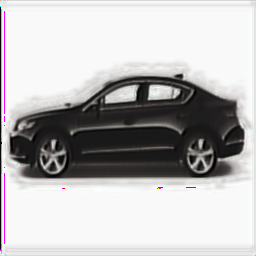

In [23]:
n_epochs = 50
loss_history = []
metric_history = []
for epoch in range(n_epochs):
    total_loss = 0
    for x, y in dataITER:
        x = (x).cuda()
        y = (y).cuda()
        model.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        total_loss += loss.item()
    mean_loss = sum(loss_history)/len(loss_history)
    scheduler.step(mean_loss)
    print("Epoch: ", epoch+1, "| Loss: ", float(loss))
    #model.to("cpu")
    display(displayingPIL(((model(X_train[2].unsqueeze(0))).squeeze(0)).to("cpu")))
    #model.to(device)

In [24]:
print(scheduler)

In [25]:
model.to("cpu")

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 6, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(6, 10, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): Conv2d(20, 40, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (7): ReLU(inplace=True)
    (8): Conv2d(40, 50, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (9): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(50, 40, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(40, 20, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(20, 10, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(10, 6, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  

In [26]:
y_pred.shape

torch.Size([2, 3, 256, 256])

In [27]:
y_train.shape

torch.Size([1000, 3, 256, 256])

In [28]:
X_train = X_train.to("cpu")
X_train.is_cuda

False

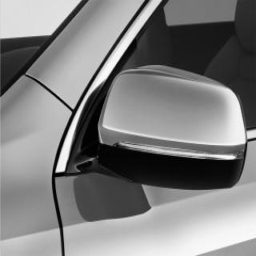

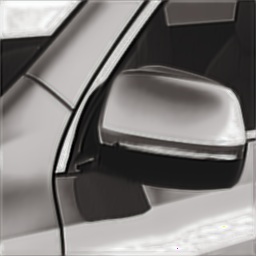

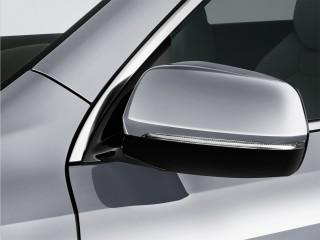

(None, None, None)

In [43]:
a = 376

display(displayingPIL(X_train[a])), display(displayingPIL((model(X_train[a].unsqueeze(0))).squeeze(0))), display(y_train_display[a])